# computing birth death rates from fortranic trajectories
Tim Tyree<br>
7.7.2022

In [1]:
from lib.my_initialization import *
from lib import *

# define module

In [2]:
def comp_death_rate(df_n,n_trgt=6):
    """measure n_trgt --> n_trgt-2 times
    
    Example Usage:
df_rate = comp_death_rates(df_n,n_trgt=6)
    """
    boo_trgt=df_n==n_trgt
    boo = ((df_n.shift(-1)==n_trgt-2)&(boo_trgt))
    if not boo.any():
        return None
    boo_event=df_n.shift(-1).diff()!=0 #for n-2 only (simple)
    event_times = boo_event[boo_event].index.values
    #boo = ((df_n.shift(-1)==n_trgt-2)&(boo_trgt))
    #count how many index values appear before each 
    dur_lst=[]
    death_rate_lst=[]
    for tf in boo[boo].index.values:
        booev = event_times<tf
        if booev.any():
            ti = np.max(event_times[booev])
            dur=tf-ti
            dur_lst.append(dur)
            death_rate_lst.append(1/dur)
    df_rate = pd.DataFrame(dict({
        'n_before':n_trgt,
        'death_rate':death_rate_lst,
        'dur':dur_lst,
    }))
    return df_rate

In [3]:
def comp_death_rates(df_n):
    """df_n is a series (time series) of numbers, indexed by time.
    comp_death_rates returns the transition rates in df_n as a pandas.DataFrame instance.
    
    Example Usage:
df_rates = comp_death_rates(df_n)
    """
    n_trgt_lst = sorted(df_n.drop_duplicates().values)
    df_rate_lst=[]
    for n_trgt in n_trgt_lst:
        df_rate = comp_death_rate(df_n,n_trgt)
        if df_rate is not None:
            df_rate_lst.append(df_rate)
    #if len(df_rate_lst)==0:
    #    return None
    df_rates = pd.concat(df_rate_lst)
    return df_rates

In [4]:
def eval_routine_compute_pair_annihilation_rates(log_folder_parquet,
    npartitions=10,
    drop_odd=True,
    testing=True,
    printing=True,**kwargs):
    """
    Example Usage:
df_rates = eval_routine_compute_pair_annihilation_rates(log_folder_parquet,
    npartitions=10,drop_odd=True,
    testing=True,printing=True)
    """
    assert os.path.exists(log_folder_parquet)

    max_trial_num=-9999
    for fn in os.listdir(log_folder_parquet):
        i=fn.find('=')
        if i>-1:
            trial_num = eval(fn[i+1:])
            if trial_num>max_trial_num:
                max_trial_num = trial_num

    #test there is no fewer files than the max_trial_num
    assert len(os.listdir(log_folder_parquet))>=max_trial_num

    if printing:
        print(f"searching {log_folder_parquet}...")
        print(f"found {max_trial_num} termination events")
        #print(f"max trial num found: {max_trial_num}")


    task_lst=[]
    for trial_num in list(range(max_trial_num+1)):
        task_lst.append((trial_num,str(log_folder_parquet)))
    if printing:
        print(f"added {len(task_lst)} tasks to task_lst!")

    def routine(task):
        trial_num,log_folder_parquet=task
        try:
            df=load_parquet_by_trial_num(trial_num=trial_num,folder_parquet=log_folder_parquet)
            df_n=df.groupby(by='t')['n'].mean()
            df_rates = comp_death_rates(df_n)
            df_rates['trial_num']=trial_num
            return df_rates
        except Exception as e:
            return None

    #fortranic spiral tip model test case
    if testing:
        task=task_lst[1]
        rv = routine(task)
        print(f"test routine returned an instance of type: {type(rv)}")
        print(f"{rv.shape=}\nrv.head(5):")
        print(rv.head(5))


    npartitions=np.min((npartitions,os.cpu_count()))
    if printing:
        print(f"computing death rates for {len(task_lst)} termination times over {npartitions} cpu cores (estimated run time <6 seconds)...")

    retval=eval_routine_daskbag(routine,task_lst,npartitions,printing=True)
    df_rates=pd.concat(retval)
    df_rates.reset_index(inplace=True)

    #identify any points with value for n_before that is odd
    descr = df_rates.groupby(by='n_before')['death_rate'].describe()
    boo_odd = 1==descr.index.values%2
    if boo_odd.any():
        if printing:
            print(f"warning: odd spiral tip counts were detected:")
            print(descr[boo_odd])

    #(optionally) drop all such odd points
    if drop_odd:
        booodd = (df_rates['n_before']%2==1)
        num_odd = np.sum(booodd)
        df_rates.drop(index=df_rates[booodd].index,inplace=True)
        if printing:
            print(f"dropped {num_odd} rows from df_rates for being odd.")
    if printing:
        print(f"rates were computed for {df_rates.shape[0]} pair-annihilation events. returning...")
    return df_rates

In [5]:
def boxplotscatter_plotter(ax,values_lst,xlabel_lst,
                           scale_scatter=0.1,
                           random_state=42,
                           ylabel='MSR (a.u.)',
                           fontsize=16,
                           marker_size = 5, 
                           marker_color = 'k', 
                           marker_alpha = .5,
                           rv_lst=None,
                           notch=True, flierprops=dict(markerfacecolor='black', marker='D'),
                           boxprops=dict(facecolor='gray'),
                           medianprops = dict(color='black'), 
                           widths = 0.5, showfliers=False,
                           **kwargs):
    """kwargs are passed directly to matplotlib.pyplot.boxplot
    
    Example Usage:
figsize=(3,4)
fig, ax = plt.subplots(figsize=figsize)   
    """
    #diamond = dict(markerfacecolor='black', marker='D')
    # mps = dict(color='black')
    np.random.seed(random_state)
    #randomly sample an x-offset for visualization purposes
    if rv_lst is None:
        rv_lst=[]
        xpos=1
        for values in values_lst:
            #sample x-offset values
            rv_1=np.random.rand(values.shape[0])
            rv=scale_scatter*(rv_1-.5)+xpos
            #record
            rv_lst.append(rv)
            #increment xpos
            xpos+=1

    #add scatter plot of data points
    for zorder,(rv,values) in enumerate(zip(rv_lst,values_lst)):
        ax.scatter(x = rv, y = values, s = marker_size, c= marker_color, alpha = marker_alpha, zorder=zorder+2)

    #add box and whisker plot
    # ax.boxplot(values, notch=True, flierprops=diamond,
    #             labels = xlabel_lst,
    #             patch_artist=True, boxprops=dict(facecolor='gray'),
    #             medianprops = mps, widths = 0.5, showfliers=False,  zorder = 1  )
    ax.boxplot(values_lst, notch=notch, flierprops=flierprops, labels = xlabel_lst,
                patch_artist=True, boxprops=boxprops, medianprops = medianprops, widths = widths, showfliers=showfliers,  zorder = 1  ,**kwargs)
    #format_plot
    format_plot(ax=ax,xlabel='',ylabel=ylabel,fontsize=fontsize)
    return ax


In [40]:
#TODO: move to lib.measures
def bootstrap_95CI_values_lst(values_lst,num_samples=1000):
    """
    Example Usage:
df_bar = bootstrap_95CI_values_lst(values_lst,num_samples=1000)
    """
    dic_lst=[]
    for values in values_lst:
        Delta_mean,p=bootstrap_95CI_Delta_mean(values,num_samples=num_samples)
        dic=dict(xbar=np.mean(values),
                 Delta_xbar=Delta_mean,
                 p_xbar=p,
                 num_obs_xbar=values.shape[0])
        dic_lst.append(dic)
    df_bar=pd.DataFrame(dic_lst)
    return df_bar

In [68]:
def recall_domain_area_parquet(log_folder_parquet,DS=0.025, round_area_to_n_digits=7):
    """DS is in units of centimeters betweeen units in the computational domain.
    recall_domain_area_parquet supposes anisotropy of a rectangular computational domain.
    
    Example Usage:
area = recall_domain_area_parquet(log_folder_parquet,DS=0.025)
    """
    df=load_parquet_by_trial_num(trial_num=0,folder_parquet=log_folder_parquet)
    width=np.around(df.x.max())
    height=np.around(df.y.max())
    area=DS**2*width*height
    return np.around(area,round_area_to_n_digits)

# dev

death_rate for n=6 --> n=4:    0.299402 Hz

Q: Does ^this agree with previously known values?


- 1/11.68 >>> 0.08561643835616438

_from wj's table for LR (A=25):_

No2, rate
2, 0.01820
3, 0.0377


- 1/0.0182 >>> 54.94505494505494
- 1/0.0377 >>> 26.525198938992045

conclusion: these rates are ~0.5X what i get from WJ's data for the LR model when diffCoeff=0.001.

THEREFORE: the annihilation rates in the LR model for Vidmar & Rappel (2019) DO in fact have diffCoeff=0.0005 for the LR model.

i.e. first pass suggests __WJ did not use tip_pos_001 to compute bdrates in Vidmar & Rappel (2019)__

In [ ]:
range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_005_creation_range_timeseries.pkl'
range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/250x250/tippos_per_001_creation_range_timeseries.pkl'


In [6]:
data_folder = f'{nb_dir}/Data'
log_folder_parquet=f'{data_folder}/from_wjr/tippos_per_001_log/'
printing=True



In [7]:
df_rates = eval_routine_compute_pair_annihilation_rates(log_folder_parquet,
    npartitions=10,drop_odd=True,
    testing=True,printing=True)

searching /home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_log/...
found 640 termination events
added 641 tasks to task_lst!
test routine returned an instance of type: <class 'pandas.core.frame.DataFrame'>
rv.shape=(17, 4)
rv.head(5):
   n_before  death_rate   dur  trial_num
0       4.0    0.043478  23.0          1
1       4.0    0.500000   2.0          1
2       4.0    0.083333  12.0          1
0       6.0    0.333333   3.0          1
1       6.0    0.020833  48.0          1
computing death rates for 641 termination times over 10 cpu cores (estimated run time <6 seconds)...
run time for evaluating routine was 5.40 seconds, yielding 641 values returned
          count  mean  std  min  25%  50%  75%  max
n_before                                           
13.0        1.0   1.0  NaN  1.0  1.0  1.0  1.0  1.0
dropped 1 rows from df_rates for being odd.
rates were computed for 16095 pair-annihilation events. returning...


In [8]:
print(f"summary stats for each particle density:")
df_rates.groupby(by='n_before')['death_rate'].describe().T

summary stats for each particle density:


n_before,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,22.0,24.0
count,2591.000000,4348.000000,4154.000000,2723.000000,1393.000000,577.000000,227.000000,62.000000,12.000000,6.000000,2.000000
mean,0.234416,0.299811,0.352814,0.423704,0.483605,0.506077,0.586733,0.595507,0.561111,0.677778,0.750000
std,0.296212,0.333146,0.342731,0.360508,0.364168,0.369552,0.362887,0.352727,0.351284,0.386820,0.353553
min,0.006494,0.007812,0.010753,0.018182,0.024390,0.027778,0.033333,0.083333,0.166667,0.066667,0.500000
25%,0.043478,0.062500,0.090909,0.125000,0.166667,0.166667,0.250000,0.270833,0.200000,0.500000,0.625000
50%,0.111111,0.142857,0.200000,0.250000,0.333333,0.333333,0.500000,0.500000,0.500000,0.750000,0.750000
75%,0.250000,0.333333,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.875000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
#generate boxplot data
values_lst=[]
xlabel_lst=[]
xval_lst=[]
for n,g in df_rates.groupby(by='n_before'):
    x=g['death_rate'].values
    values_lst.append(x)
    xlabel_lst.append(f"n: {int(n)}"+r"$\rightarrow$"+f"{int(n-2)}")
    xval_lst.append(int(n))

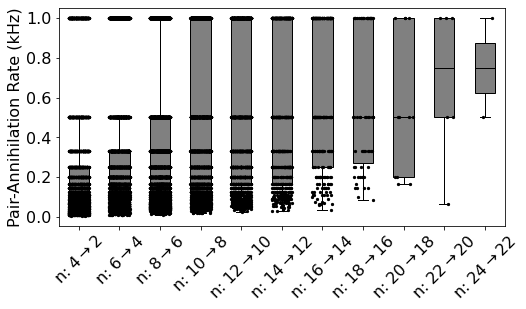

In [48]:
figsize=(8,4)
fig, ax = plt.subplots(figsize=figsize)   
boxplotscatter_plotter(ax,values_lst,xlabel_lst,random_state=42,
                           ylabel='Pair-Annihilation Rate (kHz)',fontsize=16,notch=False,scale_scatter=0.5,marker_alpha=1)#,**kwargs)
# ax.errorbar(bar_label_lst[0],bar_height_values[0],Delta_bar_height_values[0],alpha=0.9,color=color_lst[0])
# ax.set_title(title,fontsize=fontsize)
# plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.sca(ax)
plt.xticks(rotation=45)
plt.show()

In [49]:
#DONE: generate sweet boxand whisker plot
#DONE: wrapped the evaluation routine into a sweet two-linear call to my foo
#DONE: dev on two docstrings for pipeline io

[4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]

In [55]:
df_bar

,xbar,Delta_xbar,p_xbar,num_obs_xbar
0,0.234416,0.011621,5.356678e-01,2591
1,0.299811,0.009794,9.832851e-02,4348
2,0.352814,0.010557,7.050306e-02,4154
3,0.423704,0.013220,9.047911e-01,2723
4,0.483605,0.019779,6.473701e-01,1393
5,0.506077,0.031268,7.118972e-02,577
6,0.586733,0.047563,1.228405e-01,227
7,0.595507,0.082597,7.068063e-01,62
8,0.561111,0.187316,4.245290e-02,12
9,0.677778,0.285468,2.893509e-04,6


In [77]:
df_bar = bootstrap_95CI_values_lst(values_lst,num_samples=1000)
df_bar.head()

,xbar,Delta_xbar,p_xbar,num_obs_xbar
0,0.234416,0.011325,0.908178,2591
1,0.299811,0.009761,0.479242,4348
2,0.352814,0.010719,0.158870,4154
3,0.423704,0.014478,0.596363,2723
4,0.483605,0.019313,0.410485,1393


In [82]:
#TODO: print mean values with 95% ci
#HINT: 
# print(f"x --> ybar:")
# x_lst=[]
# y_lst=[]
# for x,xlabel in enumerate(xval_lst):
#     ybar=df_bar.loc[x]
#     print(f"{x} --> {dict(ybar)}")

In [86]:
#DONE: infer domain size of the folder
area = recall_domain_area_parquet(log_folder_parquet,DS=0.025)

In [87]:
use_final_n=False
#DONE: compute xy values
df_bar['n_before']=xval_lst
df_bar['death_rate']=df_bar['xbar']
df_bar['Delta_death_rate']=df_bar['Delta_xbar']
if use_final_n:
    df_bar['q']=(df_bar['n_before']-2)/area
else:
    df_bar['q']=df_bar['n_before']/area
df_bar['w']=df_bar['death_rate']/area
df_bar['Delta_w']=df_bar['Delta_death_rate']/area

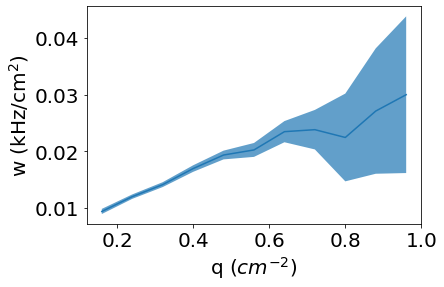

In [99]:
#TODO: visualize the apparent mean annihilation rate trace
x_values=df_bar['q'].values
y_values=df_bar['w'].values
Delta_y_values=df_bar['Delta_w'].values

plt.plot(x_values,y_values)
plt.fill_between(x_values,y_values-Delta_y_values,y_values+Delta_y_values,alpha=0.7)
# plt.xscale('log')
# plt.yscale('log')
format_plot(ax=plt.gca(),xlabel=r'q ($cm^{-2}$)',ylabel=r'w (kHz/cm$^{2}$)')
plt.show()

In [102]:
#heretim
qmax=0.4
#TODO: compute the powerlaw fit to ^this
boo=x_values<qmax
x=x_values[boo]
y=y_values[boo]
B,Delta_B,m,Delta_m,Rsq=fit_power_law(x,y)
print(f"{B=:.4f},{Delta_B=:.4f}, {m=:.4f},{Delta_m=:.4f} ({Rsq=:.4f})")
print(f"power law magnitude:\t{B:.4f} (+/- {Delta_B:.4f}) kHz/cm^(2nu-1)?")
print(f"power law exponent:\t{m:.4f} (+/- {Delta_m:.4f}) nu")


#TODO: plot the powerlaw fit to ^this

B=0.0023,Delta_B=0.0001, m=0.5909,Delta_m=0.0223 (Rsq=0.9996)
power law magnitude:	0.0023 (+/- 0.0001) kHz/cm^(2nu-1)?
power law exponent:	0.5909 (+/- 0.0223) nu


Q: what was the previous powerlaw fit?

In [105]:
wjr=recall_powerlaw_fits_to_full_models()
print(*wjr)
print_dict(wjr)

fk_pbc lr_pbc
fk_pbc={'m': 1.8772341309722325, 'Delta_m': 0.02498750277237229, 'M': 5.572315674840435, 'Delta_M': 0.3053120355191732}
lr_pbc={'m': 1.6375562704001745, 'Delta_m': 0.017190912126700632, 'M': 16.73559858353835, 'Delta_M': 0.8465090320196467}


^That's way different... I bet ^this dissagreement is because the _parquet_ cache is currently filled with creation events instead of annihilation events!  If ^this is true, then plotting the average values should appear concave instead of convex

In [106]:
#TODO: plot the powerlaw fit. is it like the annihilations or the creations?

In [ ]:
#heretim
#TODO(failing ^that/if exponents are significantly different): try using harmonic mean instead of arithmetic mean
#HINT:
from scipy.stats import hmean
hmean([1, 4])

In [ ]:
#TODO: return q,w values before averaging
#TODO: scatter plot by considering annihilation rates from many log_parquet_folders
#TODO: plot the scatter plot of all observed q,w values from many log_parquet_folders
#TODO: bootstrap an xy trace for ^that
#TODO: compute the powerlaw fit to ^this
#TODO: plot the powerlaw fit to ^this

In [27]:
#TODO: generate plot of mean annihilation rates versus particle number. save to .odg
#TODO: generate plot of mean annihilation rated density versus particle density. save to .odg
#TODO: add violinplot in the background for each xlabel in xlabel_lst
#HINT: 
# for xlabel,values in zip(xlabel_lst,values_lst,dic_lst):
#     #TOOD: plot 95% ci with violin plot
#HINT:
# for xlabel,values in zip(xlabel_lst,values_lst):
#     Delta_mean,p=bootstrap_95CI_Delta_mean(values,num_samples=1000)

In [28]:
#TODO: compute ^this powerlaw fit
#TODO: move on to computing r,kappa for ^this powerlaw fit

In [29]:
#TODO(later): use the following over a list of folders
# clean_parquet_by(folder_parquet)